In [ ]:
"""
Time Series Forecasting Project (with SARIMAX)

This script demonstrates an end-to-end time series analysis and forecasting project.
We will use the classic "Airline Passengers" dataset to predict future passenger numbers.

This version is enhanced to use a SARIMAX model, incorporating exogenous variables.

We will cover the following steps:
1.  **Setup**: Import libraries and load data.
2.  **Feature Engineering**: Create exogenous variables for the SARIMAX model.
3.  **Data Exploration (EDA)**: Visualize the series and understand its components.
4.  **Model Building**:
    - SARIMAX (SARIMA with eXogenous variables)
    - Prophet
    - Gradient Boosting (XGBoost)
5.  **Evaluation**: Compare the models' performance on a hold-out test set.

"""

In [1]:
# 1. SETUP: IMPORT LIBRARIES AND LOAD DATA
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet

# Set some styling for our plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url)

/home/davi/pyproject/portifolio/projeto_series_temporais/projeto_series_temporais/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# --- Data Preparation ---
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.rename(columns={'Passengers': 'y'}, inplace=True)

print("--- Data Head ---")
print(df.head())

--- Data Head ---
              y
Month          
1949-01-01  112
1949-02-01  118
1949-03-01  132
1949-04-01  129
1949-05-01  121


In [3]:
# 2. FEATURE ENGINEERING FOR SARIMAX
# ==============================================================================
print("\n--- Step 2: Feature Engineering for SARIMAX ---")

# Create exogenous variables
# We use one-hot encoding for the month to avoid the model treating it as a continuous variable.
df['month_exog'] = df.index.month
df = pd.get_dummies(df, columns=['month_exog'], drop_first=True, prefix='month', dtype=int)

# Create a dummy variable for a potential structural break we observe in the data's trend
df['structural_break'] = (df.index.year >= 1955).astype(int)

# Store exogenous variable names
exog_vars = [col for col in df.columns if 'month_' in col or 'structural_break' in col]
print("Created Exogenous Variables:")
print(df[exog_vars].head())


--- Step 2: Feature Engineering for SARIMAX ---
Created Exogenous Variables:
            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
Month                                                                       
1949-01-01        0        0        0        0        0        0        0   
1949-02-01        1        0        0        0        0        0        0   
1949-03-01        0        1        0        0        0        0        0   
1949-04-01        0        0        1        0        0        0        0   
1949-05-01        0        0        0        1        0        0        0   

            month_9  month_10  month_11  month_12  structural_break  
Month                                                                
1949-01-01        0         0         0         0                 0  
1949-02-01        0         0         0         0                 0  
1949-03-01        0         0         0         0                 0  
1949-04-01        0         0   


--- Step 3: Exploratory Data Analysis ---


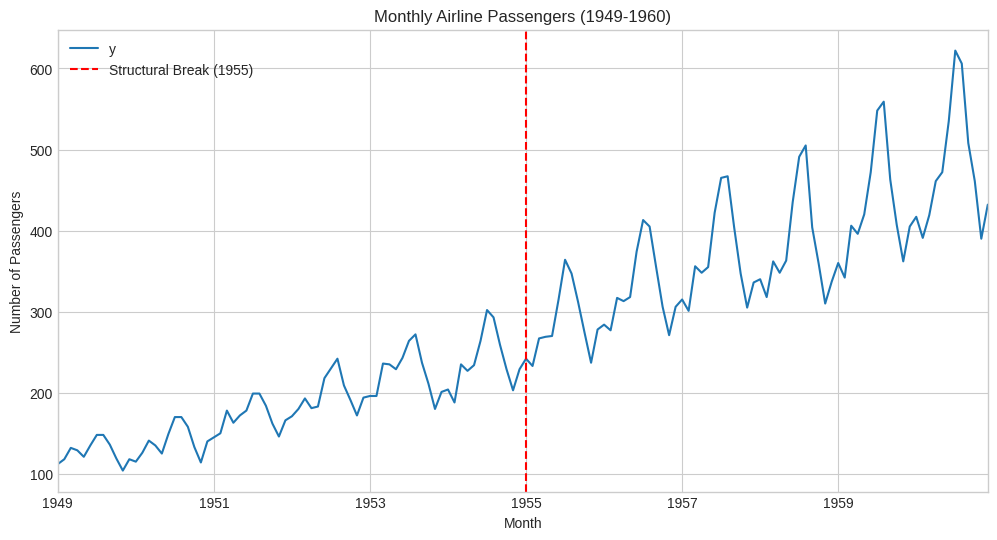

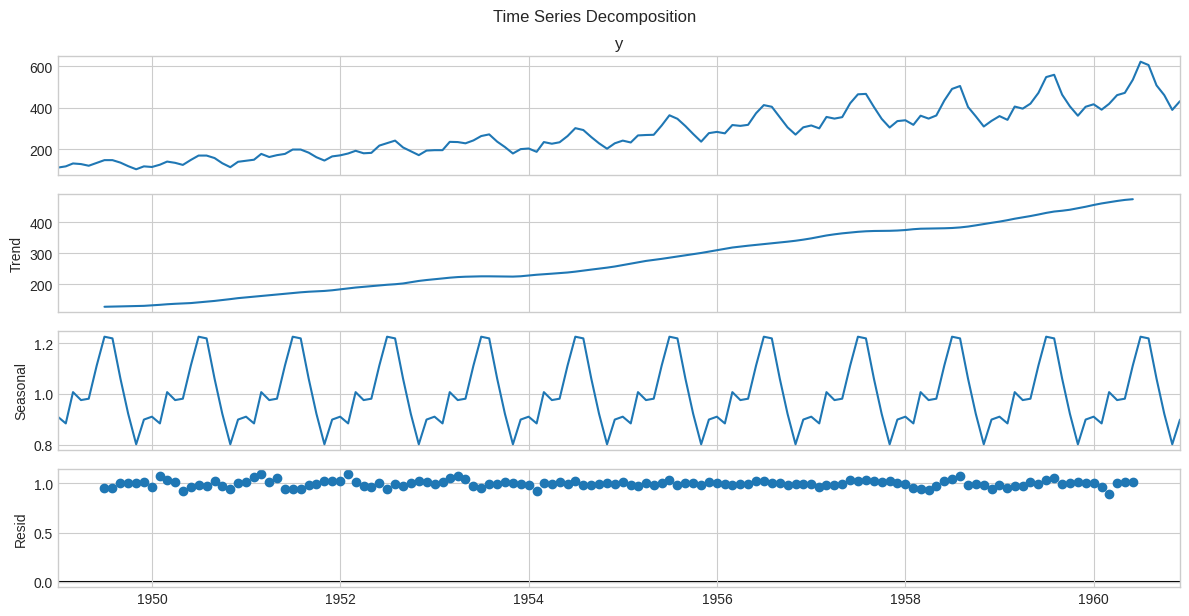

In [4]:
# 3. DATA EXPLORATION (EDA)
# ==============================================================================
print("\n--- Step 3: Exploratory Data Analysis ---")
df['y'].plot(title='Monthly Airline Passengers (1949-1960)')
plt.ylabel('Number of Passengers')
plt.xlabel('Month')
plt.axvline(pd.to_datetime('1955-01-01'), color='red', linestyle='--', label='Structural Break (1955)')
plt.legend()
plt.show()

# Decompose the time series
decomposition = seasonal_decompose(df['y'], model='multiplicative')
fig = decomposition.plot()
plt.suptitle('Time Series Decomposition', y=1.02)
plt.show()

In [5]:
# 4. MODEL BUILDING
# ==============================================================================
print("\n--- Step 4: Model Building ---")

# --- Data Splitting ---
# We need to split both our target variable and our exogenous variables
train_size = len(df) - 24
train_y, test_y = df['y'].iloc[0:train_size], df['y'].iloc[train_size:len(df)]
train_exog, test_exog = df[exog_vars].iloc[0:train_size], df[exog_vars].iloc[train_size:len(df)]

print(f"Training set size: {len(train_y)}")
print(f"Test set size: {len(test_y)}")


--- Step 4: Model Building ---
Training set size: 120
Test set size: 24


In [6]:
# --- Model 1: SARIMAX ---
print("\n--- Fitting SARIMAX Model ---")
# We can choose a simpler order for (p,d,q) because the exogenous variables
# will help explain some of the variance. We'll use (1,1,1) as a common baseline.
# The seasonal order (1,1,1,12) is kept to handle the strong yearly seasonality.
sarimax_model = SARIMAX(train_y,
                        exog=train_exog,
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

sarimax_results = sarimax_model.fit(disp=False)
print(sarimax_results.summary())

# Make predictions
# The `get_forecast` method requires the future values of the exogenous variables.
sarimax_predictions = sarimax_results.get_forecast(steps=len(test_y), exog=test_exog).predicted_mean
sarimax_predictions.index = test_y.index


--- Fitting SARIMAX Model ---


/home/davi/pyproject/portifolio/projeto_series_temporais/projeto_series_temporais/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/davi/pyproject/portifolio/projeto_series_temporais/projeto_series_temporais/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -349.577
Date:                            Tue, 15 Jul 2025   AIC                            733.154
Time:                                    08:50:22   BIC                            776.208
Sample:                                01-01-1949   HQIC                           750.538
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
month_2           2.206e-07   1.29e+05   1.71e-12      1.000   -2.53e+05    2.53e+05
month_3          

09:17:59 - cmdstanpy - INFO - Chain [1] start processing
09:17:59 - cmdstanpy - INFO - Chain [1] done processing



--- Fitting Prophet Model ---

--- Prophet Model Components ---


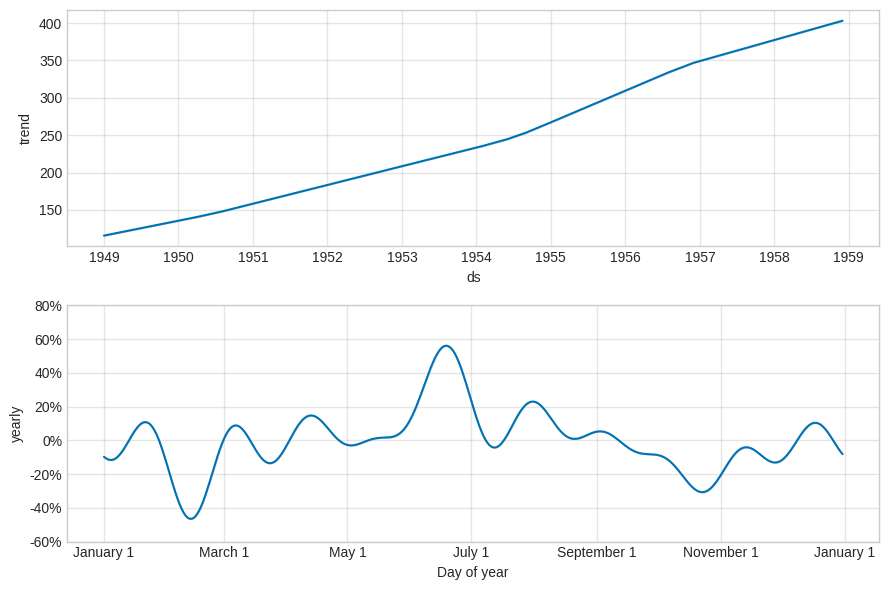

In [12]:
# --- Model 2: Prophet ---
print("\n--- Fitting Prophet Model ---")
prophet_train_df = pd.DataFrame({'ds': train_y.index, 'y': train_y.values})
prophet_model = Prophet(seasonality_mode='multiplicative')
prophet_model.fit(prophet_train_df)

# --- Visualizing Prophet Components (The "Summary") ---
print("\n--- Prophet Model Components ---")
# This is the equivalent of the summary() for Prophet
fig_components = prophet_model.plot_components(prophet_model.predict(prophet_train_df))
plt.show()

future = prophet_model.make_future_dataframe(periods=len(test_y), freq='MS')
prophet_forecast = prophet_model.predict(future)
prophet_predictions = prophet_forecast.iloc[-len(test_y):]['yhat']
prophet_predictions.index = test_y.index

In [8]:
# --- Model 3: Gradient Boosting (XGBoost) ---
print("\n--- Fitting XGBoost Model ---")
# XGBoost already uses features, so the setup is similar to SARIMAX
def create_features(df_in):
    df_feat = df_in.copy()
    df_feat['month'] = df_feat.index.month
    df_feat['year'] = df_feat.index.year
    df_feat['quarter'] = df_feat.index.quarter
    df_feat['lag1'] = df_feat['y'].shift(1)
    df_feat['lag12'] = df_feat['y'].shift(12)
    return df_feat

df_feat = create_features(df)
df_feat.dropna(inplace=True)
FEATURES = ['month', 'year', 'quarter', 'lag1', 'lag12']
TARGET = 'y'
train_feat = df_feat.iloc[:-len(test_y)]
test_feat = df_feat.iloc[-len(test_y):]

xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, objective='reg:squarederror', early_stopping_rounds=10, n_jobs=-1)
xgb_model.fit(train_feat[FEATURES], train_feat[TARGET],
              eval_set=[(train_feat[FEATURES], train_feat[TARGET]), (test_feat[FEATURES], test_feat[TARGET])],
              verbose=False)
xgb_predictions = xgb_model.predict(test_feat[FEATURES])
xgb_predictions = pd.Series(xgb_predictions, index=test_y.index)


--- Fitting XGBoost Model ---


In [9]:
# 5. EVALUATION
# ==============================================================================
print("\n--- Step 5: Model Evaluation ---")
def calculate_metrics(true_values, predictions, model_name):
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predictions)
    print(f"--- {model_name} Metrics ---")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}\n")
    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae}

# Calculate metrics for each model
sarimax_metrics = calculate_metrics(test_y, sarimax_predictions, 'SARIMAX')
prophet_metrics = calculate_metrics(test_y, prophet_predictions, 'Prophet')
xgb_metrics = calculate_metrics(test_y, xgb_predictions, 'XGBoost')


--- Step 5: Model Evaluation ---
--- SARIMAX Metrics ---
MSE: 5540.55
RMSE: 74.43
MAE: 68.81

--- Prophet Metrics ---
MSE: 923.38
RMSE: 30.39
MAE: 25.33

--- XGBoost Metrics ---
MSE: 3497.09
RMSE: 59.14
MAE: 49.36



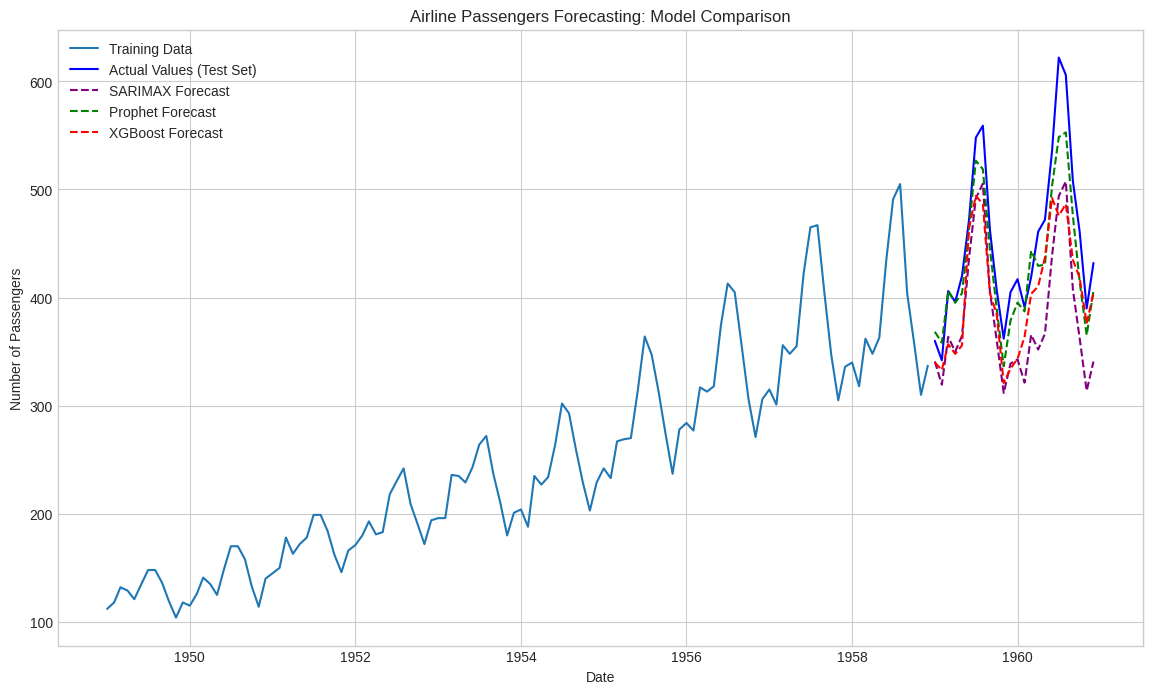

In [10]:
# --- Visualize the Forecasts ---
plt.figure(figsize=(14, 8))
plt.plot(train_y, label='Training Data')
plt.plot(test_y, label='Actual Values (Test Set)', color='blue')
plt.plot(sarimax_predictions, label='SARIMAX Forecast', color='purple', linestyle='--')
plt.plot(prophet_predictions, label='Prophet Forecast', color='green', linestyle='--')
plt.plot(xgb_predictions, label='XGBoost Forecast', color='red', linestyle='--')
plt.title('Airline Passengers Forecasting: Model Comparison')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [11]:
# --- Summary Table ---
metrics_summary = pd.DataFrame([sarimax_metrics, prophet_metrics, xgb_metrics])
print("\n--- Performance Summary ---")
print(metrics_summary.set_index('Model'))

print("\n--- Project Complete ---")


--- Performance Summary ---
              RMSE        MAE
Model                        
SARIMAX  74.434860  68.813245
Prophet  30.387247  25.330075
XGBoost  59.136216  49.358593

--- Project Complete ---
